## Setup Packages
Recommended to use [Anaconda](https://www.anaconda.com/l) in combination with an environment. Installation commands for all required packages can be found below. Choose the installation command that fits your setup.

In [1]:
# With Anaconda with GPU
!conda install ipykernel requests pandas numpy scikit-learn nltk matplotlib graphviz python-graphviz torchinfo pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
!pip install wget yfinance hiddenlayer

# With Anaconda with CPU (no GPU support)
# !conda install ipykernel requests pandas numpy scikit-learn nltk matplotlib graphviz python-graphviz pytorch torchvision torchaudio cpuonly -c pytorch
# !pip install wget yfinance hiddenlayer

# Without Anaconda with GPU
# !pip install wget yfinance hiddenlayer ipykernel requests pandas numpy scikit-learn nltk matplotlib graphviz torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# Without Anaconda with CPU (no GPU support)
# !pip install wget yfinance hiddenlayer ipykernel requests pandas numpy scikit-learn nltk matplotlib graphviz torch torchvision torchaudio

Setup all package imports to make it easier to skip code if necessary.

In [33]:
import wget, os
import zipfile
import pandas as pd
import numpy as np
import math
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from itertools import islice, cycle
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import hiddenlayer as hl
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import requests
from datetime import datetime
import yfinance as yf

## Datasets
Select and download datasets.  
  
All downloads are hosted on own Nextcloud server for consistently good performance. For dataset references please see links below.

Available datasets:  
[0](http://help.sentiment140.com/for-students) - 1,600,000 automatically labelled tweets.  
[1](https://nlp.stanford.edu/sentiment/code.html) - 10,605 manually labelled Rotten Tomatoes reviews.  
[2](https://ieee-dataport.org/open-access/stock-market-tweets-data#files) - 1,300 manually labelled financial tweets.  
[3](https://arxiv.org/abs/1307.5336) - 4,840 manually labelled fiancial news headlines.  
[4](https://github.com/ajayshewale/Sentiment-Analysis-of-Text-Data-Tweets-) - 5,970 manually labelled financial tweets.

In [3]:
# Select databases you want to use for training the model
DATASETS_SELECTED = [0]

all_urls = ["https://nextcloud.lucashost.nl/s/YfJMNRFr7H2dQCS/download/trainingandtestdata.zip", "https://nextcloud.lucashost.nl/s/iP5g97CfbqPDyDW/download/stanfordSentimentTreebank.zip", "https://nextcloud.lucashost.nl/s/pay6boDEmTESjKo/download/tweets.zip", "https://nextcloud.lucashost.nl/s/APXS5ZkeGXTSpao/download/archive.zip", "https://nextcloud.lucashost.nl/s/r4diTndweXqFYDg/download/punkt.zip"]
urls = [all_urls[i] for i in DATASETS_SELECTED]
path = "datasets/"

if not os.path.exists(path):
  os.makedirs(path)

for url in urls:
    split_url = url.split("/")
    if not (os.path.exists(path + split_url[-1])):
      wget.download(url, out = path)

In [4]:
for filename in os.listdir(path):
    if filename.endswith(".zip"):
        with zipfile.ZipFile(path + filename, 'r') as zip_ref:
            zip_ref.extractall(path)

Preprocess the differrent datasets and integrate them with eachother.

In [5]:
df = pd.DataFrame()

for i in DATASETS_SELECTED:
    if (i == 0):
        df1_manual = pd.read_csv(path + "testdata.manual.2009.06.14.csv", names=['Sentiment', 'Sentence'], usecols=[0, 5])
        df1_auto = pd.read_csv(path + "training.1600000.processed.noemoticon.csv", names=['Sentiment', 'Sentence'], usecols=[0, 5], encoding='ISO-8859-1')
        df1 = df1_auto.append(df1_manual, ignore_index=True)
        df1["Sentiment"] = df1["Sentiment"].apply(lambda sentiment: "negative" if sentiment == 0 else ("neutral" if sentiment == 2 else "positive"))
        df = df.append(df1, ignore_index=True)
    elif (i ==1):
        df2_sentence = pd.read_csv(path + "stanfordSentimentTreebank/datasetSentences.txt", sep="\t")
        df2_sentiment = pd.read_csv(path + "stanfordSentimentTreebank/sentiment_labels.txt", sep="|")
        df2 = pd.merge(df2_sentence, df2_sentiment, left_on="sentence_index", right_on="phrase ids")
        df2 = df2.drop(columns=["sentence_index", "phrase ids"])
        df2 = df2.rename(columns={"sentiment values": "Sentiment", "sentence": "Sentence"})
        df2["Sentiment"] = df2["Sentiment"].apply(lambda sentiment: "negative" if sentiment < 0.4 else ("neutral" if sentiment <= 0.6 else "positive"))
        df = df.append(df2, ignore_index=True)
    elif (i ==2):
        df3 = pd.read_csv(path + "tweets/tweets_labelled_09042020_16072020.csv", sep=";", on_bad_lines="skip")
        df3 = df3.drop(columns=["id", "created_at"])
        df3 = df3.rename(columns={"sentiment": "Sentiment", "text": "Sentence"})
        df3 = df3.dropna()
        df = df.append(df3, ignore_index=True)
    elif (i == 3):
        df4 = pd.read_csv(path + 'all-data.csv', names=['Sentiment', 'Sentence'], encoding='ISO-8859-1')
        df4['Sentiment'] = df4['Sentiment'].astype('string')
        df4['Sentence'] = df4['Sentence'].astype('string')
        df = df.append(df4, ignore_index=True)
    elif (i == 4):
        df5 = pd.read_csv(path + "train.csv")
        df5 = df5.drop(columns=["Id"])
        df5 = df5.dropna()
        df5 = df5[df5["Tweet"] != "Not Available"]
        df5 = df5[df5["Category"] != "Tweet"]
        df5 = df5.rename(columns={"Category": "Sentiment", "Tweet": "Sentence"})
        df = df.append(df5, ignore_index=True)
    else:
        print("Database " + str(i) + " not found")
df

,Sentiment,Sentence
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
1600493,neutral,Ask Programming: LaTeX or InDesign?: submitted...
1600494,negative,"On that note, I hate Word. I hate Pages. I hat..."
1600495,positive,Ahhh... back in a *real* text editing environm...
1600496,negative,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


Normalize sentences.

In [6]:
def normalize_text(sentence):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    enter_re_pattern = "\n"
    sentence = re.sub(link_re_pattern, "", sentence)
    sentence = re.sub(mention_re_pattern, "", sentence)
    sentence = re.sub(enter_re_pattern, " ", sentence)
    return sentence.lower()

df["Sentence"] = df["Sentence"].apply(normalize_text)

Over- and/or undersample sentences.

In [7]:
# How much you oversample compared to undersampling
FACTOR = 0.3

oversample_rate = math.floor((df["Sentiment"].value_counts()[0] - df["Sentiment"].value_counts()[-1]) * FACTOR)
undersample_rate = math.ceil((df["Sentiment"].value_counts()[0] - df["Sentiment"].value_counts()[-1]) * (1 - FACTOR))

most_df = df[df["Sentiment"] == df["Sentiment"].value_counts().index[0]]
mid_df = df[df["Sentiment"] == df["Sentiment"].value_counts().index[1]]
least_df = df[df["Sentiment"] == df["Sentiment"].value_counts().index[2]]

drop_indices = np.random.choice(most_df.index, size=undersample_rate, replace=False)
undersampled = most_df.drop(drop_indices, axis=0)
oversampled = least_df.append(least_df.sample(oversample_rate, replace=True))

midsample_rate = oversampled["Sentiment"].value_counts()[0] - mid_df["Sentiment"].value_counts()[0]

if (midsample_rate < 0):
    mid_drop_indices = np.random.choice(mid_df.index, -midsample_rate, replace=False)
    midsampled = mid_df.drop(mid_drop_indices)
else:
    midsampled = mid_df.append(mid_df.sample(midsample_rate, replace=True))

balanced_df = pd.concat([oversampled, midsampled, undersampled])
balanced_df["Sentiment"].value_counts()

neutral     240151
negative    240151
positive    240151
Name: Sentiment, dtype: int64

Stem sentences with the Porter Stemmer or lemmatize the sentences with the WordNet Lemmatizer.

In [8]:
USE_STEMMER = True
USE_LEMMATIZER = False

porter_stemmer  = PorterStemmer()
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[\w\d\']+(?![^\s,.\"])')

def tokenization(sentence):
    sentence = tokenizer.tokenize(sentence)
    for idx, word in enumerate(sentence):
        if (USE_STEMMER):
            sentence[idx] = porter_stemmer.stem(word)
        if (USE_LEMMATIZER):
            sentence[idx] = lemmatizer.lemmatize(word)
        else:
            sentence[idx] = word
    return sentence

balanced_df["Sentence"] = balanced_df["Sentence"].apply(tokenization)

Encoded sentences.

In [9]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for index, row in balanced_df.iterrows():
    for token in row["Sentence"]:
        if token not in index2word:
                index2word.append(token)

word2index = {token: idx for idx, token in enumerate(index2word)}
print(list(islice(word2index, 50)))

['<PAD>', '<SOS>', '<EOS>', 'check', 'this', 'video', 'out', 'president', 'obama', 'at', 'the', 'white', 'house', "correspondents'", 'dinner', 'bit', 'imxum', 'need', 'suggestions', 'for', 'a', 'good', 'ir', 'filter', 'my', 'canon', '40d', 'got', 'pls', 'dm', 'i', 'just', 'checked', 'google', 'blip', 'shows', 'up', 'as', 'second', 'huh', 'is', 'that', 'or', 'ba', '6emhv', 'in', 'san', 'francisco', 'bay', 'to']


In [10]:
def sentiment_map(sentiment):
    if sentiment == "negative":
        return 0
    elif sentiment == "neutral":
        return 1
    else: #positive
        return 2

def encode_and_pad(sentence, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]
    encoded = []

    if len(sentence) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(sentence)
        for w in sentence:
            try:
                encoded.append(word2index[w])
            except:
                encoded.append(word2index["<PAD>"])
        # encoded = [word2index[w] for w in sentence]
        return sos + encoded + eos + pad * n_pads 
    else: # sentence is longer than possible; truncating
        for w in sentence:
            try:
                encoded.append(word2index[w])
            except:
                encoded.append(word2index["<PAD>"])
        # encoded = [word2index[w] for w in sentence]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

SEQ_LENGTH = 32

encoded = [(encode_and_pad(row["Sentence"], SEQ_LENGTH), sentiment_map(row["Sentiment"])) for index, row in balanced_df.iterrows()]

Split the dataset into a training and testing set.

In [11]:
TEST_SIZE = 0.15
BATCH_SIZE = 1000

train_encoded, test_encoded = train_test_split(encoded, test_size=TEST_SIZE)

train_x = np.array([sentence for sentence, sentiment in train_encoded])
train_y = np.array([sentiment for sentence, sentiment in train_encoded])
test_x = np.array([sentence for sentence, sentiment in test_encoded])
test_y = np.array([sentiment for sentence, sentiment in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# drop_last is used to drop the final batch if does not have BATCH_SIZE elements
train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

## Neural Network

Create a LSTM neural network.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM_Sentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout1, dropout2, dropout3):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        # Input: 1x32
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Output: 32x32
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout1)
        # Output: 32x32
        self.fc1 = nn.Linear((hidden_dim*2) * (hidden_dim*2), 64)
        self.dropout3 = nn.Dropout(dropout3)
        # Output: 64
        self.fc2 = nn.Linear(64, 3)
        # Output: 3
    def forward(self, x, hidden):
        embs = self.embedding(x)
        out, hidden = self.lstm(embs, hidden)
        out = self.dropout1(out)
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = self.dropout3(out)
        out = self.fc2(out)
        return out, hidden
    def init_hidden(self, batch=BATCH_SIZE):
        return (torch.zeros(self.num_layers*2, batch, self.hidden_dim), torch.zeros(self.num_layers*2, batch, self.hidden_dim)*2)

In [13]:
LEARNING_RATE = 0.0005

model = LSTM_Sentiment(len(word2index), 32, 16, 1, 0.1, 0.2, 0.4)
model = model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-4)

LSTM_Sentiment(
  (embedding): Embedding(155706, 32, padding_idx=0)
  (lstm): LSTM(32, 16, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


C:\Users\s1847015\Miniconda3\envs\pytorch\lib\site-packages\torch\onnx\symbolic_opset9.py:2119: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +
C:\Users\s1847015\Miniconda3\envs\pytorch\lib\site-packages\torch\onnx\symbolic_opset9.py:1630: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "

(dot.exe:18840): Pango-WARNING **: couldn't load font "Times Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


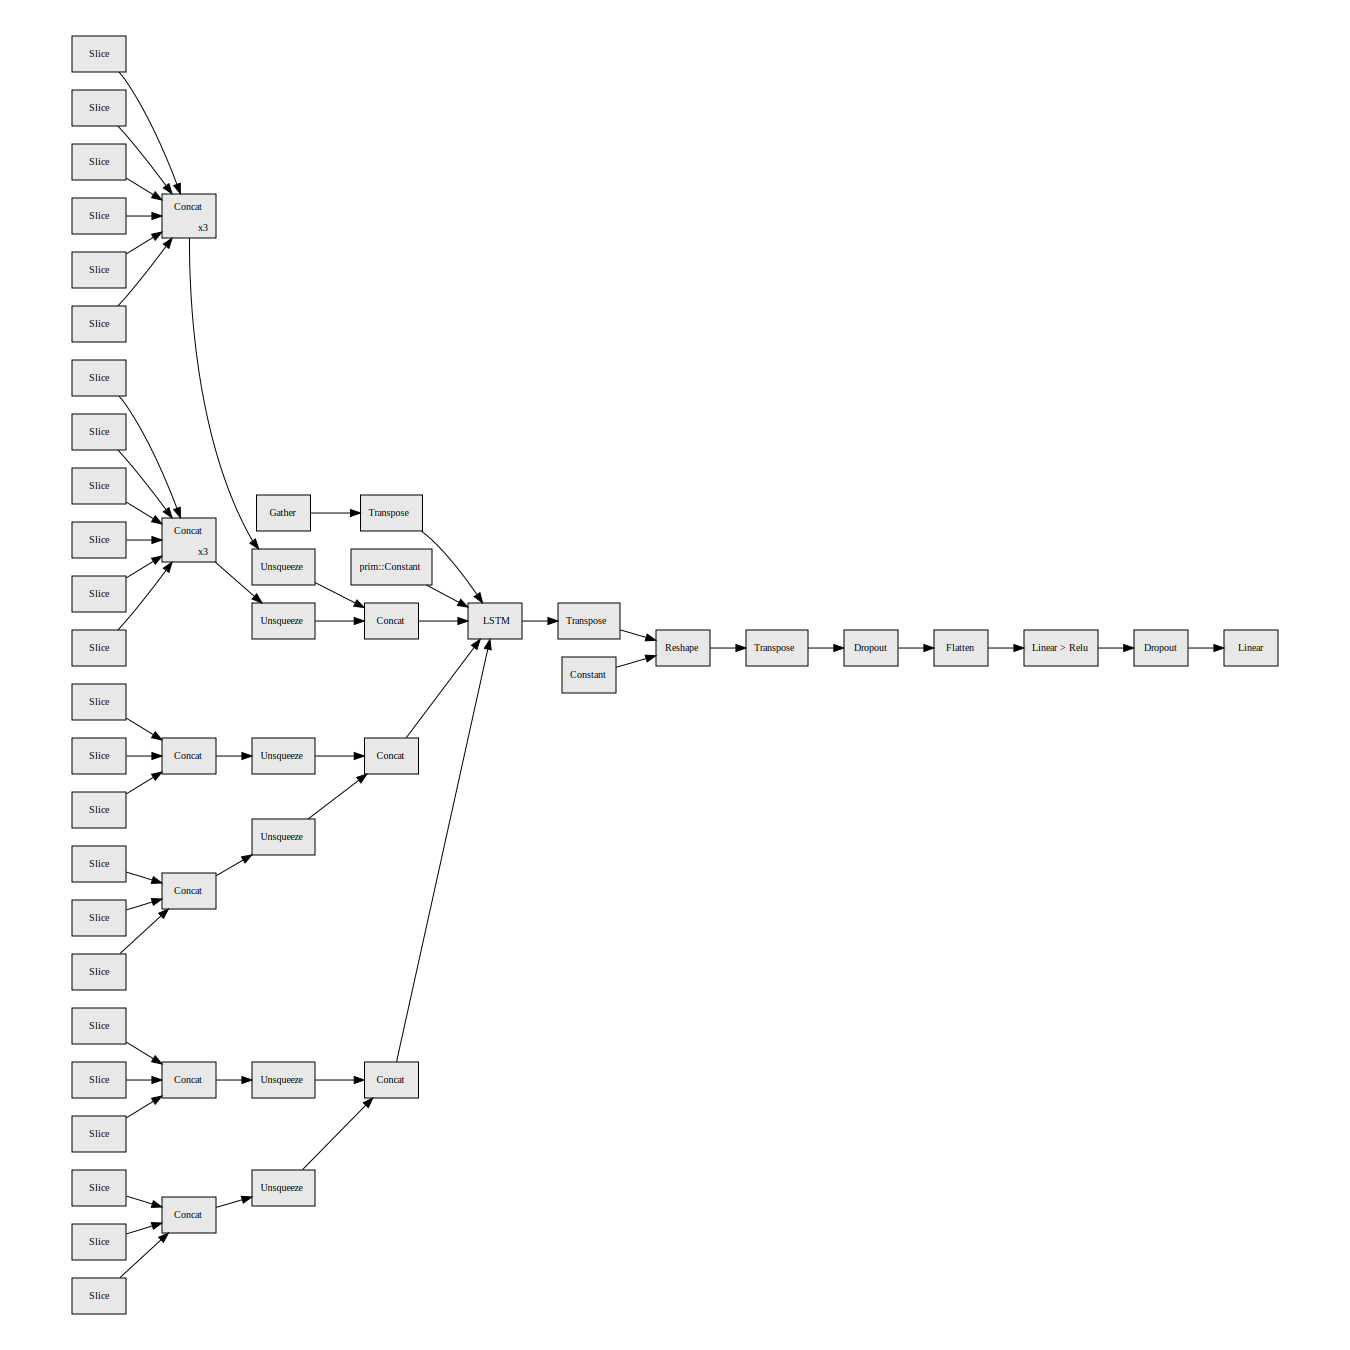

In [14]:
hl.build_graph(model, (torch.zeros([50, SEQ_LENGTH]).to(device).long(), (torch.zeros(2, 50, 16).to(device), torch.zeros(2, 50, 16).to(device))))

Train the LSTM neural network.

In [15]:
NUM_EPOCHS = 40

start=time.time()
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    # Train mode
    model.train()

    for batch_idx, batch in enumerate(train_dl):

        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            train_loss = criterion(out, target.long())
            train_loss.backward()
            optimizer.step()

        pred = torch.argmax(out, dim=1)
        correct = torch.sum(torch.eq(pred, target)).item()

        elapsed = time.time() - start
        
        if not batch_idx % (math.ceil(len(train_dl) / 4)):
            print(f'epoch: {epoch}, batch: {batch_idx:<{len(str(len(train_dl)))}}/{len(train_dl)}, time: {elapsed:.3f}s, loss: {train_loss.item():.3f}, acc: {correct / BATCH_SIZE:.3f}')
    
    train_losses.append(train_loss.item())

    # Evaluation mode
    model.eval()

    batch_acc = []
    for batch_idx, batch in enumerate(test_dl):

        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            out, hidden = model(input, (h0, c0))
            _, preds = torch.max(out, 1)
            preds = preds.to(device).tolist()
            batch_acc.append(accuracy_score(preds, target.tolist()))

            test_loss = criterion(out, target.long())

    print(f'Accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

    test_losses.append(test_loss.item())

epoch: 0, batch: 0  /612, time: 0.309s, loss: 1.104, acc: 0.329
epoch: 0, batch: 153/612, time: 4.575s, loss: 0.583, acc: 0.692
epoch: 0, batch: 306/612, time: 7.967s, loss: 0.457, acc: 0.741
epoch: 0, batch: 459/612, time: 11.430s, loss: 0.446, acc: 0.741
Accuracy on the test set: 0.779
epoch: 1, batch: 0  /612, time: 16.432s, loss: 0.410, acc: 0.782
epoch: 1, batch: 153/612, time: 20.869s, loss: 0.381, acc: 0.809
epoch: 1, batch: 306/612, time: 24.529s, loss: 0.390, acc: 0.801
epoch: 1, batch: 459/612, time: 28.185s, loss: 0.360, acc: 0.816
Accuracy on the test set: 0.809
epoch: 2, batch: 0  /612, time: 33.944s, loss: 0.385, acc: 0.813
epoch: 2, batch: 153/612, time: 37.488s, loss: 0.387, acc: 0.809
epoch: 2, batch: 306/612, time: 40.996s, loss: 0.367, acc: 0.813
epoch: 2, batch: 459/612, time: 44.479s, loss: 0.347, acc: 0.826
Accuracy on the test set: 0.829
epoch: 3, batch: 0  /612, time: 50.098s, loss: 0.339, acc: 0.837
epoch: 3, batch: 153/612, time: 53.614s, loss: 0.368, acc: 0.8

## Save model

Save the trained model.  
Skip if you don't wish to save your lastly trained model.

In [16]:
path = "model/"
if not os.path.exists(path):
  os.makedirs(path)

torch.save(model.state_dict(), path + "model.pth")

## Load model

Load the saved model from `./model/model.pth`.  
Skip if you don't wish to load the lastly saved model.

In [17]:
path = "model/"
model = LSTM_Sentiment(len(word2index), 32, 16, 1, 0.1, 0.2, 0.4)
model.load_state_dict(torch.load(path + "model.pth"))
model = model.to(device)
model.eval()

LSTM_Sentiment(
  (embedding): Embedding(155706, 32, padding_idx=0)
  (lstm): LSTM(32, 16, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

## Evaluation

Evaluate the trained model.

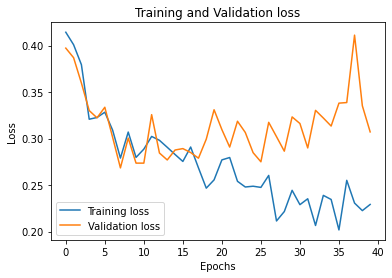

In [18]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
batch_acc = []
roc_targets = []
roc_preds = []
for batch_idx, batch in enumerate(test_dl):

    input, target = batch[0].to(device), batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to(device).tolist()
        roc_targets.extend(target.tolist())
        roc_preds.extend(preds)
        batch_acc.append(accuracy_score(preds, target.tolist()))

print(f'Final accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

Final accuracy on the test set: 0.865


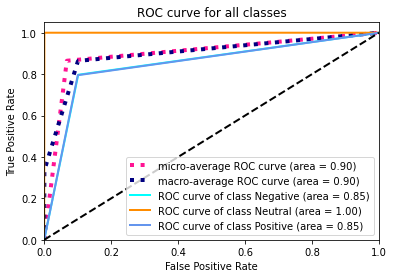

In [20]:
# Compute true positives, false positives, true negatives and false negatives for all classes
targets = [[], [], []]
preds = [[], [], []]

for i in range(3):
    for label in roc_targets:
        if (i == label):
            targets[i].append(1)
        else:
            targets[i].append(0)
    for pred in roc_preds:
        if (i == pred):
            preds[i].append(1)
        else:
            preds[i].append(0)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(targets[i]), np.array(preds[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(targets).ravel(), np.array(preds).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

lw = 2

classes = ["Negative", "Neutral", "Positive"]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for all classes")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

## Reddit API

Get Reddit posts and comments that corrospond to given keywords.

In [34]:
from auth import CLIENT_ID, SECRET_KEY, REDDIT_USERNAME, REDDIT_PASSWORD

auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)

data = {
    "grant_type": "password",
    "username": REDDIT_USERNAME,
    "password": REDDIT_PASSWORD
}

headers = {"User-Agent": "MyAPI/0.0.1"}

res = requests.post("https://www.reddit.com/api/v1/access_token", auth=auth, data=data, headers=headers)

TOKEN = res.json()["access_token"]

headers["Authorization"] = f'bearer {TOKEN}'

requests.get("https://oauth.reddit.com/api/v1/me", headers=headers).json()

{'is_employee': False,
 'seen_layout_switch': False,
 'has_visited_new_profile': False,
 'pref_no_profanity': True,
 'has_external_account': False,
 'pref_geopopular': '',
 'seen_redesign_modal': False,
 'pref_show_trending': True,
 'subreddit': {'default_set': True,
  'user_is_contributor': False,
  'banner_img': '',
  'restrict_posting': True,
  'user_is_banned': False,
  'free_form_reports': True,
  'community_icon': None,
  'show_media': True,
  'icon_color': '',
  'user_is_muted': False,
  'display_name': 'u_Rubinjo_L',
  'header_img': None,
  'title': '',
  'coins': 0,
  'previous_names': [],
  'over_18': False,
  'icon_size': [256, 256],
  'primary_color': '',
  'icon_img': 'https://styles.redditmedia.com/t5_5ga0v8/styles/profileIcon_snoo7e1baabd-7daf-4774-a95d-92829e511322-headshot.png?width=256&amp;height=256&amp;crop=256:256,smart&amp;s=5bf6cac6695af43722caff15194db1958f1fc158',
  'description': '',
  'submit_link_label': '',
  'header_size': None,
  'restrict_commenting': Fa

In [35]:
# Use company name, stock ticker and/or abbreviation of company
SEARCH = ["Adobe", "ADBE"]

df_reddit = pd.DataFrame()

for term in SEARCH:
    time.sleep(8)
    payload = {"q": term, "limit": "25", "sort": "new"}

    res = requests.get("https://oauth.reddit.com/r/subreddits/search", headers=headers, params=payload) 
    for post in res.json()["data"]["children"]:
        df_reddit = df_reddit.append({
            "subreddit": post["data"]["subreddit"],
            "postid": post["data"]["id"],
            "text": post["data"]["title"] + " " + post["data"]["selftext"],
            "created": datetime.fromtimestamp(post["data"]["created"])
        }, ignore_index=True)

df_reddit = df_reddit.drop_duplicates("postid", ignore_index=True)

for index, item in df_reddit.iterrows():
    time.sleep(8)
    payload = {"limit": "5", "sort": "new"}

    res = requests.get("https://oauth.reddit.com/r/" + item["subreddit"] + "/comments/" + item["postid"], headers=headers, params=payload)
    
    for comment in res.json()[1]["data"]["children"]:
        try:
            df_reddit = df_reddit.append({
                "subreddit": item["subreddit"],
                "text": comment["data"]["body"],
                "created": datetime.fromtimestamp(comment["data"]["created"])
            }, ignore_index=True)
        except:
            print(item["postid"] + " in the " + item["subreddit"] + " subreddit does not have enough comments.")
        
print("\nTop 3 subreddits used:")
print(df_reddit["subreddit"].value_counts()[:3])

df_reddit = df_reddit.drop(columns=["subreddit", "postid"])

skdc2i in the IndiaSpeaks subreddit does not have enough comments.
skeg67 in the BizSMG subreddit does not have enough comments.
skbii3 in the Warhammer40k subreddit does not have enough comments.
sjuxjo in the 40kLore subreddit does not have enough comments.
sjujj4 in the armenia subreddit does not have enough comments.
sjrcj5 in the GooglePixel subreddit does not have enough comments.
sjnlk7 in the BlueStacks subreddit does not have enough comments.

Top 3 subreddits used:
BizSMG         6
GooglePixel    6
armenia        5
Name: subreddit, dtype: int64


## Twitter API

Get tweets that corrospond to given keywords.

In [36]:
from auth import TWITTER_TOKEN

def auth():
    return TWITTER_TOKEN

def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

def create_url(keyword, max_results = 100):
    
    search_url = "https://api.twitter.com/2/tweets/search/recent"

    # Change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'max_results': max_results,
                    'tweet.fields': 'id,text,author_id,created_at,lang,source',
                    'next_token': {}}
    return (search_url, query_params)

def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# Inputs for the request
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "ADBE lang:en"
max_results = 100

url = create_url(keyword, max_results)
print(url)
json_response = connect_to_endpoint(url[0], headers, url[1])
df_twitter_dirty = pd.DataFrame.from_dict(json_response["data"])
df_twitter_dirty = df_twitter_dirty.drop(columns=["author_id", "source", "lang", "id"])

df_twitter = pd.DataFrame()

for index, item in df_twitter_dirty.iterrows():
    df_twitter = df_twitter.append({
                "text": item["text"],
                "created": datetime.fromisoformat(item["created_at"].replace("Z", ""))
            }, ignore_index=True)

('https://api.twitter.com/2/tweets/search/recent', {'query': 'ADBE lang:en', 'max_results': 100, 'tweet.fields': 'id,text,author_id,created_at,lang,source', 'next_token': {}})
Endpoint Response Code: 200


## Sentiment of collected data

Add data from Reddit and Twitter together and get the estimated sentiment from the trained NN. 

In [37]:
df_total_dirty = pd.concat([df_reddit, df_twitter], ignore_index=True)
df_total_dirty.head(10)

,text,created
0,Montserrat tabular/monospace font I can downlo...,2022-02-04 16:28:40
1,Discussion: OS 7-9 exclusive software Hi there...,2022-02-04 16:26:49
2,Issue with full activation of Adobe Acrobat DC...,2022-02-04 16:24:16
3,Adobe Illustrator CC 2022 26.0.3.778 Crack ReP...,2022-02-04 16:23:23
4,"Scripting , How can I visualize the Object Mod...",2022-02-04 16:21:22
5,Adobe Animate CC 2022 22.0.3.179 Crack RePack ...,2022-02-04 16:10:13
6,Export designs in XD/Figma to HTML + TailwindC...,2022-02-04 16:05:48
7,Buzzing from Leviathan with weird behavior Hi ...,2022-02-04 16:04:52
8,I reviewed my 2016 Discovery Sport. Hope you e...,2022-02-04 15:54:30
9,Cannot preview PDF files in file explorer I wa...,2022-02-04 15:53:42


In [38]:
df_total = pd.DataFrame()

for index, item in df_total_dirty.iterrows():
    df_total = df_total.append({
        "encoded_text": encode_and_pad(tokenization(normalize_text(item["text"])), SEQ_LENGTH),
        "created": item["created"]
    }, ignore_index=True)

df_total.head(10)

,encoded_text,created
0,"[1, 39451, 0, 10297, 30, 908, 3917, 19, 537, 4...",2022-02-04 16:28:40
1,"[1, 11077, 268, 25459, 1750, 160, 161, 553, 27...",2022-02-04 16:26:49
2,"[1, 7358, 62, 1880, 64657, 141, 537, 65387, 25...",2022-02-04 16:24:16
3,"[1, 537, 48971, 8592, 142703, 9992, 1722, 506,...",2022-02-04 16:23:23
4,"[1, 84124, 174, 908, 30, 104702, 10, 12536, 58...",2022-02-04 16:21:22
5,"[1, 537, 6966, 8592, 142703, 267, 1722, 506, 8...",2022-02-04 16:10:13
6,"[1, 17340, 5140, 45, 0, 49, 3314, 446, 3634, 1...",2022-02-04 16:05:48
7,"[1, 9510, 251, 16592, 62, 598, 15911, 160, 19,...",2022-02-04 16:04:52
8,"[1, 30, 15665, 24, 130220, 5146, 23046, 777, 4...",2022-02-04 15:54:30
9,"[1, 2419, 13519, 36458, 2563, 45, 2557, 4796, ...",2022-02-04 15:53:42


In [39]:
def label_map(label):
    if label == 0:
        return "negative"
    elif label == 1:
        return "neutral"
    else: #2
        return "positive"

df_labels = pd.DataFrame()

h0, c0 =  model.init_hidden(1)
h0 = h0.to(device)
c0 = c0.to(device)

optimizer.zero_grad()
with torch.set_grad_enabled(False):

    for index, item in df_total.iterrows():
        out, hidden = model(torch.tensor([item["encoded_text"]]).to(device), (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to(device).tolist()
        df_labels = df_labels.append({
            "label_cat": preds[0],
            "label": label_map(preds[0]),
            "created": item["created"]
        }, ignore_index=True)

df_labels["text"] = df_total_dirty["text"]

df_labels.head(10)

,label_cat,label,created,text
0,0.0,negative,2022-02-04 16:28:40,Montserrat tabular/monospace font I can downlo...
1,2.0,positive,2022-02-04 16:26:49,Discussion: OS 7-9 exclusive software Hi there...
2,0.0,negative,2022-02-04 16:24:16,Issue with full activation of Adobe Acrobat DC...
3,0.0,negative,2022-02-04 16:23:23,Adobe Illustrator CC 2022 26.0.3.778 Crack ReP...
4,2.0,positive,2022-02-04 16:21:22,"Scripting , How can I visualize the Object Mod..."
5,0.0,negative,2022-02-04 16:10:13,Adobe Animate CC 2022 22.0.3.179 Crack RePack ...
6,2.0,positive,2022-02-04 16:05:48,Export designs in XD/Figma to HTML + TailwindC...
7,2.0,positive,2022-02-04 16:04:52,Buzzing from Leviathan with weird behavior Hi ...
8,2.0,positive,2022-02-04 15:54:30,I reviewed my 2016 Discovery Sport. Hope you e...
9,0.0,negative,2022-02-04 15:53:42,Cannot preview PDF files in file explorer I wa...


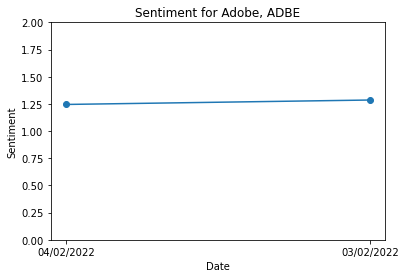

Average sentiment: 1.265


In [40]:
dates = []
df_result = pd.DataFrame()

for index, item in df_labels.iterrows():
    if item["created"].date() not in dates:
        dates.append(item["created"].date())

for date in dates:
    df_result = df_result.append({
        "sentiment": df_labels["label_cat"][df_labels["created"].apply(lambda date: date.date()) == date].mean(),
        "date": date.strftime('%d/%m/%Y')
    }, ignore_index=True)

plt.plot(df_result["date"].values.tolist(), df_result["sentiment"].values.tolist(), marker="o")
plt.ylim(0, 2)
plt.title("Sentiment for " + ", ".join(SEARCH))
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.show()

print(f'Average sentiment: {df_result["sentiment"].mean():.3f}')

## Yahoo Stock API

In [41]:
import datetime
df['StartDate'] = pd.to_datetime(df_result['date'], format='%d/%m/%Y')
least_recent_date = df['StartDate'].min()
most_recent_date = df['StartDate'].max()
most_recent_date += datetime.timedelta(days=1)
end_date = most_recent_date.strftime('%Y-%m-%d')
start_date = least_recent_date.strftime('%Y-%m-%d')

apple = yf.Ticker("AAPL")
df_stock = apple.history(interval="1d", start=start_date, end=end_date)
df_stock = df_stock.drop( df_stock.index.to_list()[0] ,axis = 0 )
df_stock = df_stock.drop(["High", "Low", "Volume", "Dividends", "Stock Splits"], axis=1)
df_stock

,Open,Close
Date,,
2022-02-03,174.479996,172.899994
2022-02-04,171.679993,171.684998


In [42]:
df_stock["stock_change"] = df_stock["Open"] - df_stock["Close"]
df_stock = df_stock.drop(["Open", "Close"], axis=1)
df_stock

,stock_change
Date,
2022-02-03,1.580002
2022-02-04,-0.005005


In [43]:
df_result["stock_change"] = df_stock["stock_change"].values.tolist()
df_result = df_result[["date", "sentiment", "stock_change"]]
df_result

,date,sentiment,stock_change
0,04/02/2022,1.244898,1.580002
1,03/02/2022,1.285714,-0.005005
